# Energy Demand Forecasting with Granite Timeseries (TTM)

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [2]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==0.2.23"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [204]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)

from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt

DATA_FILE_PATH = "/content/art_daily_jumpsdown.csv"
timestamp_column = "timestamp"
target_columns = ["value"]
context_length = 120

In [206]:
input_df = pd.read_csv(
    DATA_FILE_PATH,
    parse_dates=[timestamp_column],
)

input_df = input_df.ffill()
original_df = input_df.copy()
original_df.set_index(timestamp_column, inplace=True)
input_df = input_df.iloc[:-context_length]
input_df

,timestamp,value
0,2014-04-01 00:00:00,18.090486
1,2014-04-01 00:05:00,20.359843
2,2014-04-01 00:10:00,21.105470
3,2014-04-01 00:15:00,21.151585
4,2014-04-01 00:20:00,18.137141
...,...,...
3907,2014-04-14 13:35:00,84.747904
3908,2014-04-14 13:40:00,77.812678
3909,2014-04-14 13:45:00,74.540464
3910,2014-04-14 13:50:00,78.447027


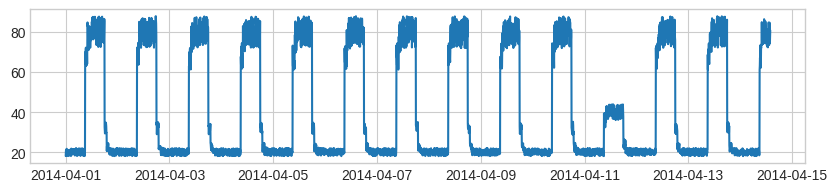

In [207]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

### Set up zero shot model
The TTM model is hosted on [Hugging Face](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.

In [208]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on Hugging Face
    num_input_channels=len(target_columns),  # tsp.num_input_channels
)

In [213]:
# Create a pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="5min",
    device=device,  # Specify your local GPU or CPU.
    prediction_length=96,  # Set the prediction length
)
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.set_index(timestamp_column, inplace=True)

Device set to use cpu


In [214]:
forecast = zeroshot_forecast[~zeroshot_forecast.index.duplicated(keep='last')]
forecast.index = pd.to_datetime(forecast.index)
forecast = zeroshot_forecast.groupby(zeroshot_forecast.index).first()
forecast

,value
timestamp,
2014-04-02 18:40:00,34.784851
2014-04-02 18:45:00,33.507893
2014-04-02 18:50:00,31.872280
2014-04-02 18:55:00,31.766006
2014-04-02 19:00:00,31.478054
...,...
2014-04-14 21:35:00,33.056595
2014-04-14 21:40:00,32.015747
2014-04-14 21:45:00,30.346611


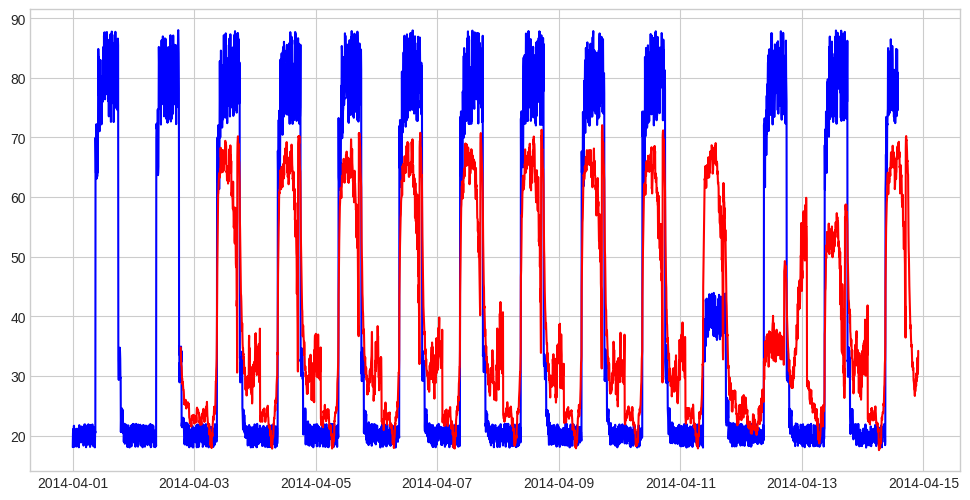

In [215]:
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(original_df.index, original_df["value"], label="Historical Data", color="blue")
ax.plot(input_df[timestamp_column], input_df["value"], label="Historical Data", color="blue")
ax.plot(forecast.index, forecast["value"], label="Pred Forecast", color="red")
plt.show()

### Forecasts as list approach

In [119]:
# Create a pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"

input_df[timestamp_column] = pd.to_datetime(input_df[timestamp_column])

pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=False,
    freq="M",
    device=device,  # Specify your local GPU or CPU.
    prediction_length=96,  # Set the prediction length
)

zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

Device set to use cpu


,date,value_prediction,value
2184,1973-08-01,"[25.24658203125, 27.146976470947266, 27.329669...","[59.29999923706055, 30.700000762939453, 23.899..."
2185,1973-09-01,"[50.94374084472656, 48.782615661621094, 48.417...","[30.700000762939453, 23.899999618530273, 23.29..."
2186,1973-10-01,"[30.656818389892578, 33.114990234375, 33.92727...","[23.899999618530273, 23.299999237060547, nan, ..."
2187,1973-11-01,"[27.677791595458984, 29.74370574951172, 31.306...","[23.299999237060547, nan, nan, nan, nan, nan, ..."
2188,1973-12-01,"[24.84244155883789, 27.424697875976562, 28.728...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
